In [281]:
import numpy as np
import pulser
from pprint import pprint
import matplotlib.pyplot as plt

from scipy.linalg import expm

from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.waveforms import RampWaveform
from pulser.devices import Chadoq2

In [282]:
# Parameters in rad/µs and ns
Omega = 1 *2*np.pi
delta = 0.7*2*np.pi
U = 138e5

C6 = Chadoq2.interaction_coeff
print(Chadoq2.interaction_coeff)

d = Chadoq2.rydberg_blockade_radius(Omega)
print(d)
print((C6/Omega)**(1/6))

# print((U/Omega)**(1/6))
# Omega = Omega/U*C6
# delta = delta/U*C6
# d = Chadoq2.rydberg_blockade_radius(Omega)
# print(d)

5420158.53
9.756753962298905
9.756753962298905


4.535564562432278


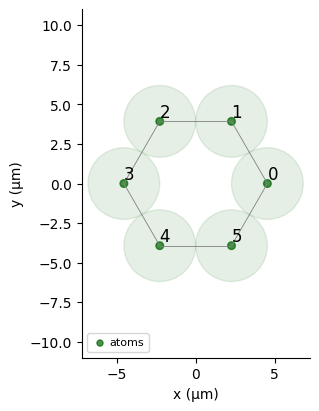

In [283]:
rNN = 5.3 / (U/C6)**(1/6.) # Scaling of position to match interaction coefficient
print(rNN)
#G1 = [(0,rNN/2),(0,-rNN/2),(rNN*np.sqrt(3)/2,0),(rNN*np.sqrt(3)/2+rNN,0),(rNN*np.sqrt(3)+rNN,rNN/2),(rNN*np.sqrt(3)+rNN,-rNN/2)]

G1 = [(rNN*np.cos(2*np.pi*j/6),rNN*np.sin(2*np.pi*j/6)) for j in range(6) ]

qubits1 = dict(enumerate(G1))
B1 = [0,1,2,3,4,5]
C1 = [0,1,2,3,4,5]
reg1 = Register(qubits1)
reg1.draw(blockade_radius=rNN, draw_half_radius=True, draw_graph=True)

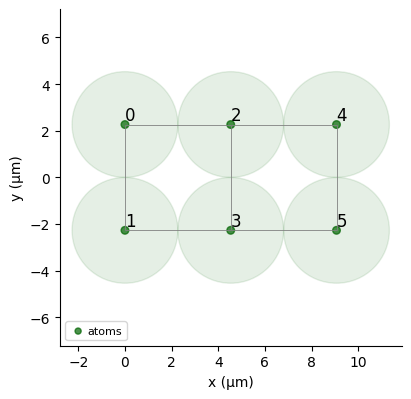

In [284]:
G2 = [(0,rNN/2),(0,-rNN/2),(rNN,rNN/2),(rNN,-rNN/2),(2*rNN,rNN/2),(2*rNN,-rNN/2)]

#G2 = [(rNN/1.9*np.cos(2*np.pi*j/3),rNN/1.9*np.sin(2*np.pi*j/3)) for j in range(3) ] + [(2*rNN-rNN/1.9*np.cos(2*np.pi*j/3),rNN/1.9*np.sin(2*np.pi*j/3)) for j in range(3) ]

#G2 = [(rNN*2*np.cos(2*np.pi*j/6),rNN*2*np.sin(2*np.pi*j/6)) for j in range(6) ]

B2 = [0,1,2,3,4,5]
C2 = [0,1,2,3,4,5]

qubits2 = dict(enumerate(G2))
reg2 = Register(qubits2)

reg2.draw(blockade_radius=rNN, draw_half_radius=True, draw_graph=True)

In [285]:
M = 100
T = 1000*np.linspace(0.05,2.5,M)
t_pulses = [Pulse.ConstantPulse(int(t),Omega,delta,0) for t in T]


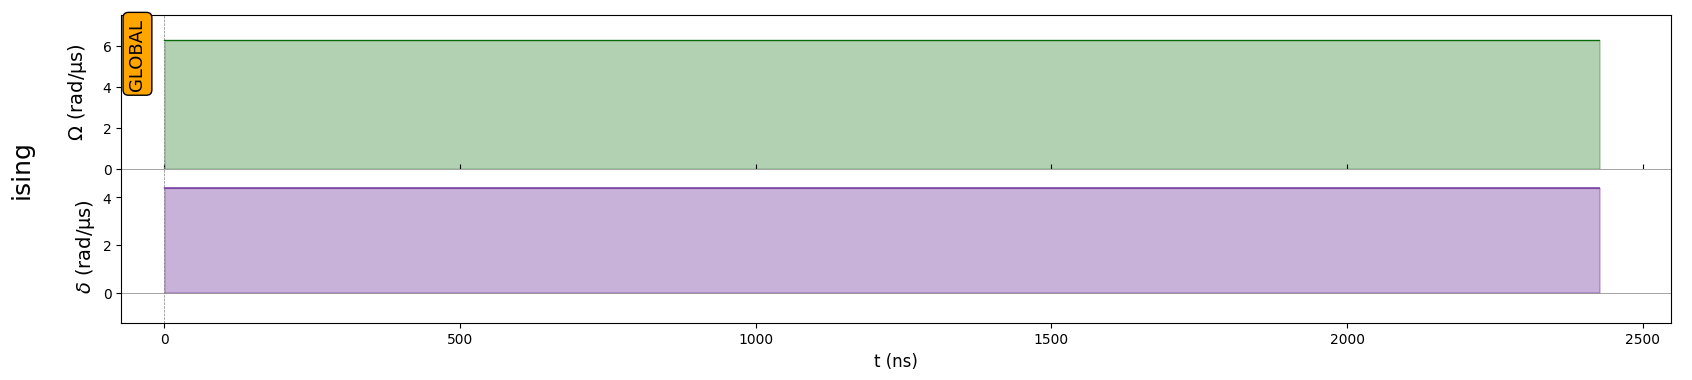

In [286]:
mydevice = pulser.devices.VirtualDevice('Mydevice', dimensions=2, rydberg_level=70)
seq = Sequence(reg1, mydevice)

seq = Sequence(reg1, Chadoq2)

seq.declare_channel("ising", "rydberg_global")
#seq.available_channels

seq.add(t_pulses[-4],"ising")
#seq.measure(basis="ground-rydberg")
seq.draw()

In [287]:
seq.declared_channels

{'ising': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 15.707963267948966 rad/µs, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg')}

In [288]:
sim = QutipEmulator.from_sequence(seq, sampling_rate=0.1)

# results = sim.run(progress_bar=True)
# print(results.sample_final_state(N_samples=1000))

In [289]:
N_samples = 250
n_qubits = 6

# count_dict = results.sample_final_state(N_samples=N_samples)


n1_B = np.zeros(M)
n1_C = np.zeros(M)
n2_B = np.zeros(M)
n2_C = np.zeros(M)



for i,t in enumerate(T):

    t_pulse = Pulse.ConstantPulse(int(t),Omega,delta,0)
    seq = Sequence(reg1, Chadoq2)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(t_pulse,"ising")

    sim = QutipEmulator.from_sequence(seq, sampling_rate=0.1)
    results = sim.run(progress_bar=False)
    count_dict = results.sample_final_state(N_samples=N_samples)
    
    for el,count in count_dict.items():
        for j,qubitval in enumerate(el[::-1]):
            if j in B1 and qubitval=="1":
                n1_B[i] += count / N_samples / len(B1)
            elif j in C1 and qubitval=="1":
                n1_C[i] += count / N_samples / len(C1)

    seq = Sequence(reg2, Chadoq2)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(t_pulse,"ising")
    
    sim = QutipEmulator.from_sequence(seq, sampling_rate=0.1)
    results = sim.run(progress_bar=False)
    count_dict = results.sample_final_state(N_samples=N_samples)
    
    for el,count in count_dict.items():
        for j,qubitval in enumerate(el[::-1]):
            if j in B2 and qubitval=="1":
                n2_B[i] += count / N_samples / len(B2)
            elif j in C2 and qubitval=="1":
                n2_C[i] += count / N_samples / len(C2)



In [290]:
def Kron(*arr):
    K = arr[0]
    for i in range(1,len(arr)):
        K = np.kron(K,arr[i])
    return K

I = np.eye(2)
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])

Xi = np.concatenate(([Kron(X,I,I,I,I,I)],[Kron(*([I]*i+[X]+[I]*(6-i-1))) for i in range(1,5)],[Kron(I,I,I,I,I,X)]))
Zi = np.concatenate(([Kron(Z,I,I,I,I,I)],[Kron(*([I]*i+[Z]+[I]*(6-i-1))) for i in range(1,5)],[Kron(I,I,I,I,I,Z)]))
Ni = (np.eye(2**6)+Zi)/2


rNN = 5.3
Omega = 1   * 2*np.pi
delta = 0.7 * 2*np.pi

H = Omega/2*np.sum(Xi, axis=0) - delta*np.sum(Ni, axis=0)
#G1 = [(0,rNN/2),(0,-rNN/2),(rNN*np.sqrt(3)/2,0),(rNN*np.sqrt(3)/2+rNN,0),(rNN*np.sqrt(3)+rNN,rNN/2),(rNN*np.sqrt(3)+rNN,-rNN/2)]
#G2 = [(0,rNN/2),(0,-rNN/2),(rNN,rNN/2),(rNN,-rNN/2),(2*rNN,rNN/2),(2*rNN,-rNN/2)]
B = [0,1,2,3,4,5]
C = [0,1,2,3,4,5]
# U = 138*1e5
# U = 5420158.53
# U = 1.38e6

Rij1 = np.zeros((6,6))
for i in range(6):
    for j in range(i):
        Rij1[i,j] = np.linalg.norm(np.array(G1[i])-np.array(G1[j]))
        Rij1[j,i] = Rij1[i,j]
        
H1 = H.copy()
for i in range(6):
    for j in range(i):
        H1 += U/Rij1[i,j]**6 * (Ni[i]@Ni[j])# + Ni[j]@Ni[i])/2
        
Rij2 = np.zeros((6,6))
for i in range(6):
    for j in range(i):
        Rij2[i,j] = np.linalg.norm(np.array(G2[i])-np.array(G2[j]))
        Rij2[j,i] = Rij2[i,j]
        
H2 = H.copy()
for i in range(6):
    for j in range(i):
        H2 += U/Rij2[i,j]**6 * (Ni[i]@Ni[j])# + Ni[j]@Ni[i])/2

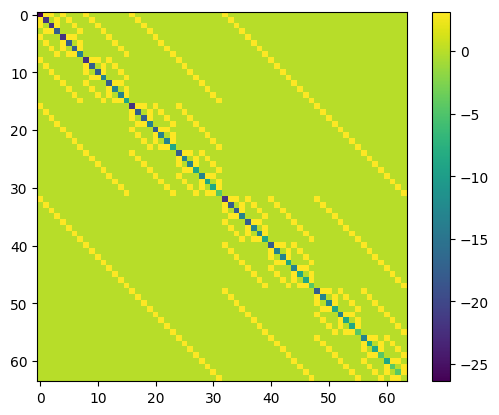

In [291]:
plt.imshow(H)
plt.colorbar()

In [292]:
v = Kron(*[np.array([0,1])]*6)

def Obs(v,A):
    return (np.sum( [v.transpose().conj()@Ni[i]@v for i in A] )).real/len(A)

In [293]:
# T = np.linspace(0.05,2.5,M)

#O1_B = np.zeros((M))
#O1_C = np.zeros((M))
#O2_B = np.zeros((M))
#O2_C = np.zeros((M))
#for i,t in enumerate(T):
#    vt = expm(-1j*t*H1/1000)@v
#    O1_B[i] = Obs(vt,B)
#    O1_C[i] = Obs(vt,C)
    
#    vt = expm(-1j*t*H2/1000)@v
#    O2_B[i] = Obs(vt,B)
#    O2_C[i] = Obs(vt,C)

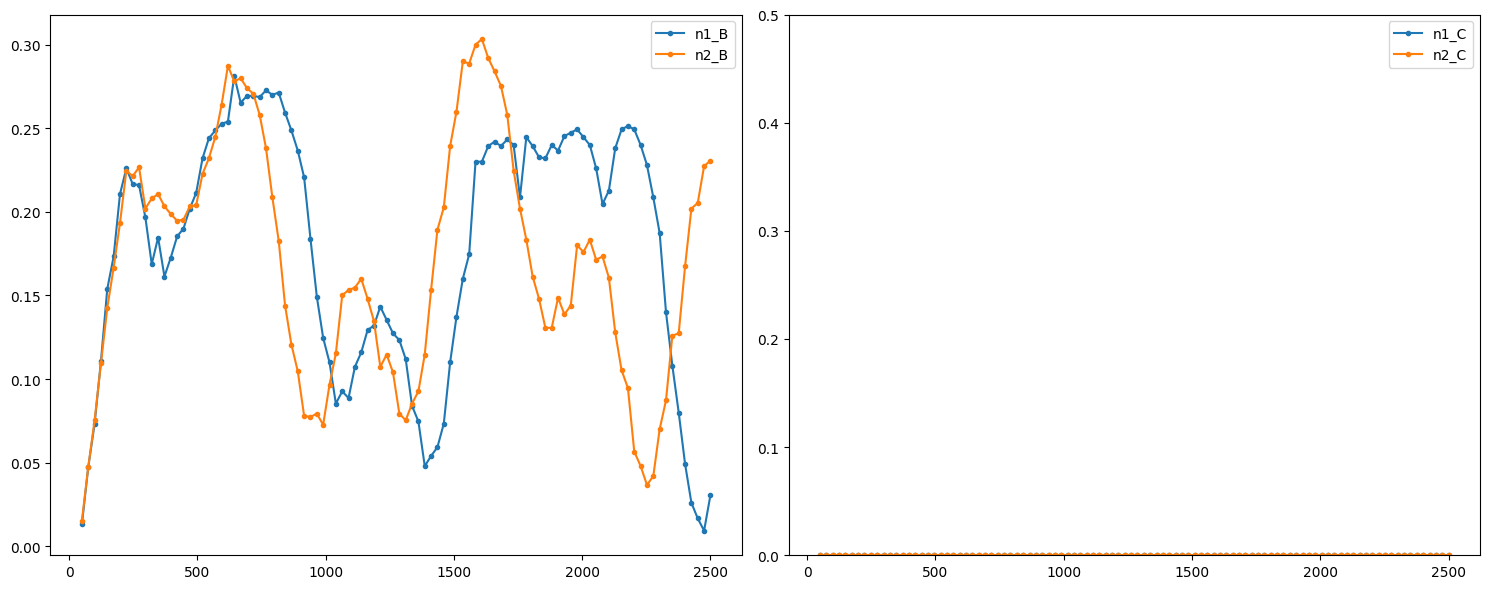

In [294]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 6))

ax1.plot(T,n1_B,'.-',label="n1_B")
ax1.plot(T,n2_B,'.-',label="n2_B")
#ax1.plot(T,O1_B,label="n1_B_theory")
#ax1.plot(T,O2_B,label="n2_B_theory")
plt.ylim([0,0.5])

ax2.plot(T,n1_C,'.-',label="n1_C")
ax2.plot(T,n2_C,'.-',label="n2_C")
#ax2.plot(T,O1_C,label="n1_C_theory")
#ax2.plot(T,O2_C,label="n2_C_theory")
#ax2.ylim([0,0.5])

ax1.legend()
ax2.legend()

plt.tight_layout()

plt.show()